# Lab 2. LLM Quantization Lab

This lab source is partly based on

- EfficientML.ai Lab https://hanlab.mit.edu/courses/2023-fall-65940
- KoAlpaca+GPTQ git https://github.com/qwopqwop200/GPTQ-for-KoAlpaca

## Part1. LLM Quantization with GPTQ, AWQ, and NF4

### Package pip install & import (~3m)

In [ ]:
print('Installing packages...')
!pip install -U git+https://github.com/huggingface/transformers.git
!pip install -U git+https://github.com/huggingface/accelerate.git
!pip install datasets
!pip install torch tqdm
!pip install -U bitsandbytes

#### 런타임 - 세션 다시 시작

In [2]:
# Import Libraries
import tqdm
import torch
from torch import nn
from transformers import AutoModelForCausalLM, AutoTokenizer, GPTQConfig, BitsAndBytesConfig
import datasets
from datasets import load_dataset
from functools import partial
import gc
import copy

In [3]:
# Set evaluation
def evaluate(model, tokenizer):
    testenc = load_dataset('wikitext', 'wikitext-2-raw-v1', split='test')
    testenc = tokenizer("\n\n".join(testenc['text']), return_tensors='pt')

    testenc = testenc.input_ids.to(model.device)
    nsamples = 40
    model = model.eval()

    nlls = []
    for i in tqdm.tqdm(range(nsamples), desc="evaluating..."):
        batch = testenc[:, (i * 2048):((i + 1) * 2048)].to(model.device)
        with torch.no_grad():
            lm_logits = model(batch).logits
        shift_logits = lm_logits[:, :-1, :].contiguous().float()
        shift_labels = testenc[:, (i * 2048):((i + 1) * 2048)][:, 1:]
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        neg_log_likelihood = loss.float() * 2048
        nlls.append(neg_log_likelihood)

    return torch.exp(torch.stack(nlls).sum() / (nsamples * 2048))


### Part1-0. FP Model

Let's build and load small language model (OPT-125m) on GPU

In [4]:
model_path = "facebook/opt-125m"

In [5]:
model_path = "facebook/opt-125m"
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)
fp_model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
for para in fp_model.parameters():
    para.requires_grad = False
fp_model.config.use_cache = False
fp_model.eval()
gc.collect()
torch.cuda.empty_cache()
print(fp_model)
print(f"Parameter data type: {fp_model.dtype}")

/home/devrok/.conda/envs/snuenv_pt/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


OPTForCausalLM(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 768, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 768)
      (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-11): 12 x OPTDecoderLayer(
          (self_attn): OPTAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), ep

In [6]:
layer_number = 2 # number of layer
fp_model.model.decoder.layers[layer_number].self_attn.k_proj.weight[0][:8]

tensor([-0.0091,  0.1550,  0.0509, -0.0707, -0.0919, -0.0008, -0.0420, -0.0068],
       device='cuda:0')

In [13]:
# Model Size (GB)
fp_model_memory = 0.6

In [8]:
# Evaluate the model
fp_model_perplexity = evaluate(fp_model, tokenizer)
print(f"\nFP model perplexity: {fp_model_perplexity:.2f}")
gc.collect()
torch.cuda.empty_cache()

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

evaluating...: 100%|██████████| 40/40 [00:07<00:00,  5.52it/s]



FP model perplexity: 27.57


In [14]:
# FP model perplexity: 27.57
fp_model_ppl = 0.27

### Part1-1 Fake RTN Quantization

In [10]:
sample_weight = copy.deepcopy(fp_model.model.decoder.layers[0].self_attn.q_proj.weight).to('cpu')
sample_weight.requires_grad = False
print(sample_weight)
org_w_shape = sample_weight.shape
print(org_w_shape)

bit = 4
max_int = 2**bit -1
min_int = 0

group_size = 64
assert org_w_shape[-1] % group_size == 0
print(f"bit: {bit}, max_int: {max_int}, min_int: {min_int}, group size: {group_size}")

tensor([[ 0.0800,  0.2443, -0.2681,  ..., -0.2683, -0.0035, -0.0454],
        [-0.1362,  0.0869, -0.0869,  ...,  0.0484,  0.0303, -0.0471],
        [ 0.1505,  0.1498,  0.0703,  ...,  0.0029, -0.0348, -0.0657],
        ...,
        [ 0.0299,  0.1112,  0.0060,  ...,  0.0621, -0.0052,  0.0376],
        [ 0.0058,  0.0356,  0.0091,  ...,  0.0012,  0.0155,  0.0274],
        [-0.0443,  0.1431,  0.0268,  ..., -0.0435, -0.0213,  0.0091]])
torch.Size([768, 768])
bit: 4, max_int: 15, min_int: 0, group size: 64


In [11]:
# Reshape for group-wise quantization
# 768, 768 -> 9216, 64
sample_weight = sample_weight.reshape(-1, group_size)
print(sample_weight)
print(sample_weight.shape)

tensor([[ 0.0800,  0.2443, -0.2681,  ..., -0.0565, -0.2128,  0.0113],
        [ 0.0428, -0.0458, -0.0250,  ..., -0.1627,  0.0767,  0.0225],
        [-0.0306,  0.2065,  0.0231,  ...,  0.2520, -0.0304,  0.3813],
        ...,
        [-0.0323,  0.0507, -0.0175,  ...,  0.0205,  0.0484,  0.0206],
        [-0.0118, -0.1013,  0.0663,  ..., -0.0229, -0.0729,  0.0233],
        [ 0.0206,  0.0016, -0.0005,  ..., -0.0435, -0.0213,  0.0091]])
torch.Size([9216, 64])


In [12]:
# Get min, max value
tmp = torch.zeros(sample_weight.shape[0])
min = torch.minimum(sample_weight.min(1)[0], tmp)
max = torch.maximum(sample_weight.max(1)[0], tmp)
print(f"min: {min}, shape: {min.shape}")
print(f"max: {max}, shape: {max.shape}")

min: tensor([-0.3540, -0.2964, -0.2661,  ..., -0.0752, -0.1013, -0.1242]), shape: torch.Size([9216])
max: tensor([0.2483, 0.1881, 0.3813,  ..., 0.1097, 0.0663, 0.0942]), shape: torch.Size([9216])


In [13]:
# Symmetric Quantization
print("Symmetric Quantization")
print(f"Bit: {bit}, group_size: {group_size}\n")

sym_max = torch.maximum(torch.abs(min), max)
sym_tmp = min < 0
if torch.any(sym_tmp):
    sym_min = copy.deepcopy(min)[sym_tmp] = - sym_max[sym_tmp]
sym_tmp = (sym_min == 0) & (sym_max == 0) # zero tensor
sym_min[sym_tmp] = -1
sym_max[sym_tmp] = +1
# 64 Size의 9216개 group 존재
print(f"symmetric min: {sym_min}")
print(f"symmetric max: {sym_max}")

sym_scale = (sym_max - sym_min) / max_int
print(f"symmetric scale: {sym_scale}, shape: {sym_scale.shape}")

sym_zero = torch.full_like(sym_scale, (max_int + 1)/2)
print(f"symmetric zero: {sym_zero}, shape: {sym_zero.shape}")
# Actually, symmetric quantization use fixed zero -> (max_int + 1)/2

# Symmetric quantized weights
sym_q_weight = torch.clamp(torch.round(sample_weight / sym_scale.reshape(-1,1)) + sym_zero.reshape(-1,1), min_int, max_int).reshape(org_w_shape)
print(f"\nsymmetric quantized weight: \n{sym_q_weight}")
# 4bit -> 0 ~ 15까지로 표현
print(f"symmetric quantized weight unique: \n{torch.unique(sym_q_weight)}")
print(sym_q_weight.shape)

# Symmetric Fake Quantization
fake_sym_w = ((sym_q_weight.reshape(-1, group_size) - sym_zero.reshape(-1,1))*sym_scale.reshape(-1,1)).reshape(org_w_shape)
print(f"\nfake symmetric quantized weight: \n{fake_sym_w}")
print(fake_sym_w.shape)

Symmetric Quantization
Bit: 4, group_size: 64

symmetric min: tensor([-0.3540, -0.2964, -0.3813,  ..., -0.1097, -0.1013, -0.1242])
symmetric max: tensor([0.3540, 0.2964, 0.3813,  ..., 0.1097, 0.1013, 0.1242])
symmetric scale: tensor([0.0472, 0.0395, 0.0508,  ..., 0.0146, 0.0135, 0.0166]), shape: torch.Size([9216])
symmetric zero: tensor([8., 8., 8.,  ..., 8., 8., 8.]), shape: torch.Size([9216])

symmetric quantized weight: 
tensor([[10., 13.,  2.,  ...,  1.,  8.,  7.],
        [ 5., 10.,  6.,  ...,  9.,  9.,  7.],
        [14., 14., 11.,  ...,  8.,  7.,  6.],
        ...,
        [10., 14.,  8.,  ..., 12.,  8., 11.],
        [ 8., 11.,  9.,  ...,  8.,  9., 10.],
        [ 6., 15.,  9.,  ...,  5.,  7.,  9.]])
symmetric quantized weight unique: 
tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15.])
torch.Size([768, 768])

fake symmetric quantized weight: 
tensor([[ 0.0944,  0.2360, -0.2832,  ..., -0.2650,  0.0000, -0.0379],
        [-0.1261,  0.

In [15]:
# Asymmetric Quantization
print("Asymmetric Quantization")
print(f"Bit: {bit}, group_size: {group_size}\n")

asym_max = copy.deepcopy(max)
asym_min = copy.deepcopy(min)

asym_tmp = (asym_min == 0) & (asym_max==0)
asym_max[asym_tmp] = -1
asym_min[asym_tmp] = +1

print(f"asymmetric min: {asym_min}")
print(f"asymmetric max: {asym_max}")

asym_scale = (asym_max - asym_min) / max_int
print(f"asymmetric scale: {asym_scale}, shape: {asym_scale.shape}")

asym_zero = torch.round(-asym_min / asym_scale)
print(f"asymmetric zero: {asym_zero}, shape: {asym_zero.shape}")


# Asymmetric quantized weights
asym_q_weight = torch.clamp(torch.round(sample_weight / asym_scale.reshape(-1,1)) + asym_zero.reshape(-1,1), min_int, max_int).reshape(org_w_shape)
print(f"\nasymmetric quantized weight: \n{asym_q_weight}")
print(f"asymmetric quantized weight unique: \n{torch.unique(asym_q_weight)}")
print(asym_q_weight.shape)

# Asymmetric Fake Quantization
fake_asym_w = ((asym_q_weight.reshape(-1, group_size) - asym_zero.reshape(-1,1))*asym_scale.reshape(-1,1)).reshape(org_w_shape)
print(f"\nfake assymetric quantized weight: \n{fake_asym_w}")
print(fake_asym_w.shape)

Asymmetric Quantization
Bit: 4, group_size: 64

asymmetric min: tensor([-0.3540, -0.2964, -0.2661,  ..., -0.0752, -0.1013, -0.1242])
asymmetric max: tensor([0.2483, 0.1881, 0.3813,  ..., 0.1097, 0.0663, 0.0942])
asymmetric scale: tensor([0.0402, 0.0323, 0.0432,  ..., 0.0123, 0.0112, 0.0146]), shape: torch.Size([9216])
asymmetric zero: tensor([9., 9., 6.,  ..., 6., 9., 9.]), shape: torch.Size([9216])

asymmetric quantized weight: 
tensor([[11., 15.,  2.,  ...,  0.,  7.,  6.],
        [ 2.,  8.,  4.,  ...,  9.,  9.,  7.],
        [14., 14., 11.,  ...,  8.,  7.,  6.],
        ...,
        [10., 15.,  8.,  ..., 11.,  6.,  9.],
        [ 9., 11.,  9.,  ...,  6.,  7.,  8.],
        [ 2., 15.,  7.,  ...,  6.,  8., 10.]])
asymmetric quantized weight unique: 
tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15.])
torch.Size([768, 768])

fake assymetric quantized weight: 
tensor([[ 0.0803,  0.2409, -0.2811,  ..., -0.2595,  0.0000, -0.0371],
        [-0.1

'\ntensor([[ 0.0800,  0.2443, -0.2681,  ..., -0.2683, -0.0035, -0.0454],\n        [-0.1362,  0.0869, -0.0869,  ...,  0.0484,  0.0303, -0.0471],\n        [ 0.1505,  0.1498,  0.0703,  ...,  0.0029, -0.0348, -0.0657],\n        ...,\n        [ 0.0299,  0.1112,  0.0060,  ...,  0.0621, -0.0052,  0.0376],\n        [ 0.0058,  0.0356,  0.0091,  ...,  0.0012,  0.0155,  0.0274],\n        [-0.0443,  0.1431,  0.0268,  ..., -0.0435, -0.0213,  0.0091]])\n\n------> tensor([[11., 15.,  2.,  ...,  0.,  7.,  6.],\n                [ 2.,  8.,  4.,  ...,  9.,  9.,  7.],\n                [14., 14., 11.,  ...,  8.,  7.,  6.],\n                ...,\n                [10., 15.,  8.,  ..., 11.,  6.,  9.],\n                [ 9., 11.,  9.,  ...,  6.,  7.,  8.],\n                [ 2., 15.,  7.,  ...,  6.,  8., 10.]]\n'

In [ ]:
'''
tensor([[ 0.0800,  0.2443, -0.2681,  ..., -0.2683, -0.0035, -0.0454],
        [-0.1362,  0.0869, -0.0869,  ...,  0.0484,  0.0303, -0.0471],
        [ 0.1505,  0.1498,  0.0703,  ...,  0.0029, -0.0348, -0.0657],
        ...,
        [ 0.0299,  0.1112,  0.0060,  ...,  0.0621, -0.0052,  0.0376],
        [ 0.0058,  0.0356,  0.0091,  ...,  0.0012,  0.0155,  0.0274],
        [-0.0443,  0.1431,  0.0268,  ..., -0.0435, -0.0213,  0.0091]])

------> tensor([[11., 15.,  2.,  ...,  0.,  7.,  6.],
                [ 2.,  8.,  4.,  ...,  9.,  9.,  7.],
                [14., 14., 11.,  ...,  8.,  7.,  6.],
                ...,
                [10., 15.,  8.,  ..., 11.,  6.,  9.],
                [ 9., 11.,  9.,  ...,  6.,  7.,  8.],
                [ 2., 15.,  7.,  ...,  6.,  8., 10.]]
'''

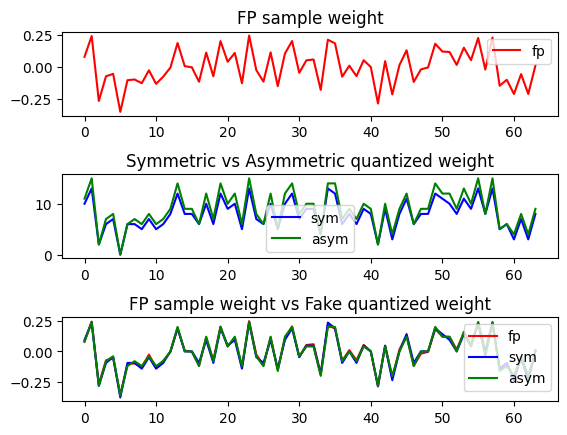

In [16]:
import matplotlib.pyplot as plt

plt.subplot(3,1,1)
plt.plot(sample_weight[0][:64].numpy(), color="red", label="fp")
plt.title("FP sample weight")
plt.legend()


plt.subplot(3,1,2)
plt.plot(sym_q_weight[0][:64].numpy(), color="blue", label="sym")
plt.plot(asym_q_weight[0][:64].numpy(), color="green", label="asym")
plt.legend()
plt.title("Symmetric vs Asymmetric quantized weight")

plt.subplot(3,1,3)
plt.plot(sample_weight[0][:64].numpy(), color="red", label="fp")
plt.plot(fake_sym_w[0][:64].numpy(), color="blue", label="sym")
plt.plot(fake_asym_w[0][:64].numpy(), color="green", label="asym")
plt.legend()
plt.title("FP sample weight vs Fake quantized weight")

plt.subplots_adjust(hspace=0.7)

In [ ]:
loss = nn.MSELoss()
fp_sym = loss(sample_weight.reshape(org_w_shape), sym_q_weight)
fp_asym = loss(sample_weight.reshape(org_w_shape), asym_q_weight)
print(f" symmetric quantization loss: {fp_sym}")
print(f"asymmetric quantization loss: {fp_asym}")

 symmetric quantization loss: 71.27777862548828
asymmetric quantization loss: 66.93885040283203


### Part1-2 NormalFloat 4bit Quantization


- 런타임 - 세션 다시 시작

In [1]:
# Import Libraries
import tqdm
import torch
from torch import nn
from transformers import AutoModelForCausalLM, AutoTokenizer, GPTQConfig, BitsAndBytesConfig
import datasets
from datasets import load_dataset
from functools import partial
import gc
import copy

In [2]:
# Set evaluation
def evaluate(model, tokenizer):
    testenc = load_dataset('wikitext', 'wikitext-2-raw-v1', split='test')
    testenc = tokenizer("\n\n".join(testenc['text']), return_tensors='pt')

    testenc = testenc.input_ids.to(model.device)
    nsamples = 40
    model = model.eval()

    nlls = []
    for i in tqdm.tqdm(range(nsamples), desc="evaluating..."):
        batch = testenc[:, (i * 2048):((i + 1) * 2048)].to(model.device)
        with torch.no_grad():
            lm_logits = model(batch).logits
        shift_logits = lm_logits[:, :-1, :].contiguous().float()
        shift_labels = testenc[:, (i * 2048):((i + 1) * 2048)][:, 1:]
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        neg_log_likelihood = loss.float() * 2048
        nlls.append(neg_log_likelihood)

    return torch.exp(torch.stack(nlls).sum() / (nsamples * 2048))

In [3]:
# Load model in NF4
model_path = "facebook/opt-125m"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float32
)
q_model_nf = AutoModelForCausalLM.from_pretrained(model_path, quantization_config=bnb_config, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)
print(q_model_nf)
gc.collect()
torch.cuda.empty_cache()

OPTForCausalLM(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 768, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 768)
      (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-11): 12 x OPTDecoderLayer(
          (self_attn): OPTAttention(
            (k_proj): Linear4bit(in_features=768, out_features=768, bias=True)
            (v_proj): Linear4bit(in_features=768, out_features=768, bias=True)
            (q_proj): Linear4bit(in_features=768, out_features=768, bias=True)
            (out_proj): Linear4bit(in_features=768, out_features=768, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear4bit(in_features=768, out_features=3072, bias=True)
          (fc2): Linear4bit(in_features=3072, out_features=768, bias=True)
          (final_layer_nor

/home/devrok/.conda/envs/snuenv_pt/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [21]:
q_model_nf_memory = 0.2

In [4]:
# Evaluate the NF4 quantized model
q_model_nf_perplexity = evaluate(q_model_nf, tokenizer)
print(f"\nNF4 model perplexity: {q_model_nf_perplexity:.2f}")
gc.collect()
torch.cuda.empty_cache()

evaluating...:   0%|          | 0/40 [00:00<?, ?it/s]/home/devrok/.conda/envs/snuenv_pt/lib/python3.10/site-packages/bitsandbytes/nn/modules.py:435: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(
evaluating...: 100%|██████████| 40/40 [00:06<00:00,  6.32it/s]



NF4 model perplexity: 29.20


In [22]:
q_model_nf_ppl = 0.29

Structure of NormalFloat 4bit

In [6]:
print(q_model_nf.model.decoder.layers[0].self_attn.k_proj)
print(q_model_nf.model.decoder.layers[0].self_attn.k_proj.weight)
print(q_model_nf.model.decoder.layers[0].self_attn.k_proj.weight.shape)
# 768 * 768 / 2 = 294912

Linear4bit(in_features=768, out_features=768, bias=True)
Parameter containing:
Parameter(Params4bit([[199],
            [113],
            [185],
            ...,
            [138],
            [ 74],
            [ 26]], device='cuda:0', dtype=torch.uint8))
torch.Size([294912, 1])


In [7]:
print(q_model_nf.model.decoder.layers[0].self_attn.k_proj.quant_state.absmax)
print(q_model_nf.model.decoder.layers[0].self_attn.k_proj.quant_state.absmax.shape)
# 768 * 768 / 64 = 9216

tensor([0.1979, 0.3286, 0.2496,  ..., 0.1274, 0.1580, 0.1471], device='cuda:0')
torch.Size([9216])


In [8]:
print(q_model_nf.model.decoder.layers[0].self_attn.k_proj.quant_state.blocksize)

64


In [9]:
# Nonuniform Quantization
print(q_model_nf.model.decoder.layers[0].self_attn.k_proj.quant_state.code)

tensor([-1.0000, -0.6962, -0.5251, -0.3949, -0.2844, -0.1848, -0.0911,  0.0000,
         0.0796,  0.1609,  0.2461,  0.3379,  0.4407,  0.5626,  0.7230,  1.0000],
       device='cuda:0')


### Part1-3. GPTQ INT4 Quantization

Let's quantize OPT-125m with GPTQ 4-bit


- 런타임 - 런타임 연결해제 및 삭제

In [1]:
print('Installing packages...')
!pip install -U git+https://github.com/huggingface/transformers.git
!pip install -U git+https://github.com/huggingface/accelerate.git
!pip install datasets
!pip install torch tqdm
!pip install autoawq
!pip install -U auto-gptq optimum
!pip install --upgrade torchvision

Installing packages...
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-brwnxur3
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-brwnxur3
  Resolved https://github.com/huggingface/transformers.git to commit c35d2ccf5a5ebcab24a0b9da3cb2527b3ae565a0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
DEPRECATION: pytorch-lightning 1.6.1 has a non-standard dependency specifier torch>=1.8.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Cloning https://github.com/huggingface/accelerate.git to /tmp/pip-req-build-_lffx37u
  Running command git clone --filter=blob:

- 세션 다시 시작

In [2]:
# Import Libraries
import tqdm
import torch
from torch import nn
from transformers import AutoModelForCausalLM, AutoTokenizer, GPTQConfig, BitsAndBytesConfig
import datasets
from datasets import load_dataset
from functools import partial
import gc
import copy

In [3]:
# 4-bit GPTQ with OPT-125m (group size = 128)
model_path = "facebook/opt-125m"
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)
quantization_config = GPTQConfig(bits=4, dataset = "c4", tokenizer=tokenizer)
q_model_gptq = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto", quantization_config=quantization_config)

for para in q_model_gptq.parameters():
    para.requires_grad = False
q_model_gptq.config.use_cache = False
q_model_gptq.eval()
#print(q_model_gptq)
gc.collect()
torch.cuda.empty_cache()

/home/devrok/.conda/envs/snuenv_pt/lib/python3.10/site-packages/auto_gptq/nn_modules/triton_utils/kernels.py:411: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, input, qweight, scales, qzeros, g_idx, bits, maxq):
/home/devrok/.conda/envs/snuenv_pt/lib/python3.10/site-packages/auto_gptq/nn_modules/triton_utils/kernels.py:419: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_output):
/home/devrok/.conda/envs/snuenv_pt/lib/python3.10/site-packages/auto_gptq/nn_modules/triton_utils/kernels.py:461: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd(cast_inputs=torch.float16)
CUDA extension not installed.
CUDA extension not installed.


Generating train split: 0 examples [00:00, ? examples/s]

Quantizing model.decoder.layers blocks :   0%|          | 0/12 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

/home/devrok/.conda/envs/snuenv_pt/lib/python3.10/site-packages/transformers/modeling_utils.py:4674: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(


In [4]:
q_model_gptq.save_pretrained("opt-125m-gptq")
tokenizer.save_pretrained("opt-125m-gptq")

('opt-125m-gptq/tokenizer_config.json',
 'opt-125m-gptq/special_tokens_map.json',
 'opt-125m-gptq/vocab.json',
 'opt-125m-gptq/merges.txt',
 'opt-125m-gptq/added_tokens.json')


- 런타임 - 세션 다시 시작

In [1]:
# Import Libraries
import tqdm
import torch
from torch import nn
from transformers import AutoModelForCausalLM, AutoTokenizer, GPTQConfig, BitsAndBytesConfig
import datasets
from datasets import load_dataset
from functools import partial
import gc
import copy

In [2]:
# Set evaluation
def evaluate(model, tokenizer):
    testenc = load_dataset('wikitext', 'wikitext-2-raw-v1', split='test')
    testenc = tokenizer("\n\n".join(testenc['text']), return_tensors='pt')

    testenc = testenc.input_ids.to(model.device)
    nsamples = 40
    model = model.eval()

    nlls = []
    for i in tqdm.tqdm(range(nsamples), desc="evaluating..."):
        batch = testenc[:, (i * 2048):((i + 1) * 2048)].to(model.device)
        with torch.no_grad():
            lm_logits = model(batch).logits
        shift_logits = lm_logits[:, :-1, :].contiguous().float()
        shift_labels = testenc[:, (i * 2048):((i + 1) * 2048)][:, 1:]
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        neg_log_likelihood = loss.float() * 2048
        nlls.append(neg_log_likelihood)

    return torch.exp(torch.stack(nlls).sum() / (nsamples * 2048))

In [3]:
q_model_gptq = AutoModelForCausalLM.from_pretrained("opt-125m-gptq", device_map="auto")
tokenizer = AutoTokenizer.from_pretrained("opt-125m-gptq", use_fast=False)
print(q_model_gptq)
gc.collect()
torch.cuda.empty_cache()

/home/devrok/.conda/envs/snuenv_pt/lib/python3.10/site-packages/auto_gptq/nn_modules/triton_utils/kernels.py:411: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, input, qweight, scales, qzeros, g_idx, bits, maxq):
/home/devrok/.conda/envs/snuenv_pt/lib/python3.10/site-packages/auto_gptq/nn_modules/triton_utils/kernels.py:419: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_output):
/home/devrok/.conda/envs/snuenv_pt/lib/python3.10/site-packages/auto_gptq/nn_modules/triton_utils/kernels.py:461: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd(cast_inputs=torch.float16)
CUDA extension not installed.
CUDA extension not installed.
/home/devrok/.conda/envs/snuenv_pt/

OPTForCausalLM(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 768, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 768)
      (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-11): 12 x OPTDecoderLayer(
          (self_attn): OPTAttention(
            (k_proj): QuantLinear()
            (out_proj): QuantLinear()
            (q_proj): QuantLinear()
            (v_proj): QuantLinear()
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (fc1): QuantLinear()
          (fc2): QuantLinear()
        )
      )
    )
  )
  (lm_head): Linear(in_features=768, out_features=50272, bias=False)
)


In [16]:
q_model_gptq_memory = 0.2

In [4]:
q_model_gptq_perplexity = evaluate(q_model_gptq, tokenizer)
print(f"\n GPTQ 4-bit model perplexity: {q_model_gptq_perplexity:.2f}")
gc.collect()
torch.cuda.empty_cache()

evaluating...: 100%|██████████| 40/40 [00:05<00:00,  7.62it/s]



 GPTQ 4-bit model perplexity: 30.73


In [17]:
q_model_gptq_ppl = 0.3

How does quantized model looks like?

In [7]:
model_layers = q_model_gptq.model.decoder.layers
layer_number = 2 # number of layer

print(f"Inspect Layer {layer_number} k_proj : {model_layers[layer_number].self_attn.k_proj}")
qweight = model_layers[layer_number].self_attn.k_proj.qweight

# qweight shape (opt-125m hidden dimension : 768)
print(f"qweight shape is .. {qweight.shape}")
print(f"qweight dim[0] is {q_model_gptq.config.hidden_size / qweight.shape[0]} times smaller than FP weight.")
# 4 Byte 단위로 4 bit로 8개씩 group (packing)
# qweight values
print(f"\nqweight \n{qweight}")

Inspect Layer 2 k_proj : QuantLinear()
qweight shape is .. torch.Size([96, 768])
qweight dim[0] is 8.0 times smaller than FP weight.

qweight 
tensor([[-2021164632, -1469610328, -2021095271,  ...,  1261607046,
         -1971885448,  2058831980],
        [-2022139783, -2005497700,  2022217879,  ..., -1969448600,
         -1721271896,   -92760726],
        [-2005370744, -1466402474, -2004776568,  ..., -1178027653,
         -2005354344,   986195894],
        ...,
        [-2019198583, -1432840278, -1431938951,  ...,  2041994678,
         -1197712742,  1638631864],
        [-1968600984, -1471568171, -2022210203,  ..., -1437301403,
          -647317672,  -613968008],
        [-1498122378,  1235630762, -1466455658,  ..., -1470671212,
           915831641,  -897095869]], device='cuda:0', dtype=torch.int32)


In [8]:
# Let's check packed weight!
def binary(x, bits):
    mask = 2**torch.arange(bits).to(x.device, x.dtype)
    return x.unsqueeze(-1).bitwise_and(mask).ne(0).byte()

def int_to_dec(x):
    temp = 0
    for i in range(len(x)):
        temp += 2**i * x[-i-1]
    return temp

print(f"Original qweight: {qweight[0,0]}")
print()
print("Unpacked 8 parameters")
for i in range(8):
    unpacked = binary(qweight[0,0], 32)[4*i:4*(i+1)].cpu().numpy()
    print(f"{str(unpacked)} {int_to_dec(unpacked)}")

Original qweight: -2021164632

Unpacked 8 parameters
[0 0 0 1] 1
[0 1 0 1] 5
[1 0 0 1] 9
[1 1 1 0] 14
[1 1 1 0] 14
[0 0 0 1] 1
[1 1 1 0] 14
[0 0 0 1] 1


In [9]:
# Let's check quantizaion scale!
print(f"scale is {model_layers[layer_number].self_attn.k_proj.scales}")
print(f"\nscale dimension {model_layers[layer_number].self_attn.k_proj.scales.shape}")
print(f"scale dim[0] is {q_model_gptq.config.hidden_size / model_layers[layer_number].self_attn.k_proj.scales.shape[0]} times smaller than original weight")

scale is tensor([[0.0670, 0.0364, 0.0293,  ..., 0.0229, 0.0607, 0.0264],
        [0.0658, 0.0665, 0.0079,  ..., 0.0219, 0.0313, 0.0530],
        [0.0277, 0.0292, 0.0365,  ..., 0.0286, 0.0243, 0.0254],
        [0.0548, 0.0276, 0.0410,  ..., 0.0337, 0.0441, 0.0453],
        [0.0205, 0.0359, 0.0275,  ..., 0.0276, 0.0313, 0.0358],
        [0.0287, 0.0242, 0.0114,  ..., 0.0248, 0.0250, 0.0257]],
       device='cuda:0', dtype=torch.float16)

scale dimension torch.Size([6, 768])
scale dim[0] is 128.0 times smaller than original weight


In [10]:
# Let's check quantizaion zeros!
print(f"qzeros is {model_layers[layer_number].self_attn.k_proj.qzeros[:2, :10]}")
print(f"\nqzeros dimension {model_layers[layer_number].self_attn.k_proj.qzeros.shape}")
print(f"qzeros dim[0] is {q_model_gptq.config.hidden_size / model_layers[layer_number].self_attn.k_proj.qzeros.shape[0]} times smaller than original weight")
print(f"qzeros dim[1] is {q_model_gptq.config.hidden_size / model_layers[layer_number].self_attn.k_proj.qzeros.shape[1]} times smaller than original weight")

qzeros is tensor([[2004318071, 2004318071, 2004318071, 2004318071, 2004318071, 2004318071,
         2004318071, 2004318071, 2004318071, 2004318071],
        [2004318071, 2004318071, 2004318071, 2004318071, 2004318071, 2004318071,
         2004318071, 2004318071, 2004318071, 2004318071]], device='cuda:0',
       dtype=torch.int32)

qzeros dimension torch.Size([6, 96])
qzeros dim[0] is 128.0 times smaller than original weight
qzeros dim[1] is 8.0 times smaller than original weight


In [11]:
# Let's check packed zeros!
qzeros = model_layers[layer_number].self_attn.k_proj.qzeros[0,0]

print(qzeros)
print()
for i in range(8):
   unpacked = binary(qzeros, 32)[4*i:4*(i+1)].cpu().numpy()
   print(f"{str(unpacked)} {int_to_dec(unpacked)}")

tensor(2004318071, device='cuda:0', dtype=torch.int32)

[1 1 1 0] 14
[1 1 1 0] 14
[1 1 1 0] 14
[1 1 1 0] 14
[1 1 1 0] 14
[1 1 1 0] 14
[1 1 1 0] 14
[1 1 1 0] 14


### Part1-4. AWQ INT4 Quantization


- 런타임 - 세션 다시 시작

In [1]:
# Import Libraries
import tqdm
import torch
from torch import nn
from transformers import AutoModelForCausalLM, AutoTokenizer, GPTQConfig, BitsAndBytesConfig
import datasets
from datasets import load_dataset
from functools import partial
import gc
import copy

In [2]:
from awq import AutoAWQForCausalLM
from transformers import AutoTokenizer

model_path = "facebook/opt-125m"
#quant_path = 'opt-125m-awq'
quant_config = { "zero_point": True, "q_group_size": 128 }

# Load model
q_model_awq = AutoAWQForCausalLM.from_pretrained(model_path, safetensors=False)
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)

# for para in q_model_awq.parameters():
#     para.requires_grad = False
# q_model_awq.config.use_cache = False
# q_model_awq.eval()
# gc.collect()
# torch.cuda.empty_cache()

Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/7.10k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

LICENSE.md:   0%|          | 0.00/11.1k [00:00<?, ?B/s]

In [3]:
print(q_model_awq.model.model.decoder.layers[0].self_attn.k_proj.weight)
print(q_model_awq.model.model.decoder.layers[0].self_attn.k_proj.weight.shape)
print(q_model_awq.model.model.decoder.layers[0].self_attn.k_proj.weight.dtype)

Parameter containing:
tensor([[ 7.8796e-02,  9.4938e-04,  6.5308e-03,  ..., -4.6875e-02,
          3.9642e-02,  1.1843e-04],
        [ 2.0361e-01,  1.6589e-01, -3.3989e-03,  ..., -4.5959e-02,
         -4.7058e-02, -4.8035e-02],
        [ 3.6865e-02,  1.2341e-01,  3.0731e-02,  ..., -8.3252e-02,
          2.4887e-02,  1.9882e-02],
        ...,
        [ 8.6426e-02,  2.7046e-03, -4.4518e-03,  ..., -1.8738e-02,
          2.8839e-02,  4.8431e-02],
        [ 9.1064e-02,  6.3049e-02,  7.2327e-02,  ..., -1.2463e-01,
          1.1230e-01,  2.4750e-02],
        [-9.3460e-04, -2.8748e-02,  2.5269e-02,  ...,  3.5706e-02,
         -1.1932e-01,  3.1067e-02]], dtype=torch.float16, requires_grad=True)
torch.Size([768, 768])
torch.float16


Manually conduct AWQ

In [4]:
test_awq_model = copy.deepcopy(q_model_awq)
for para in test_awq_model.parameters():
     para.requires_grad = False

from awq.quantize.quantizer import AwqQuantizer
test_awq_model.quantizer = AwqQuantizer(
    test_awq_model,
    test_awq_model.model,
    tokenizer,
    test_awq_model.quant_config.w_bit,
    test_awq_model.quant_config.q_group_size,
    test_awq_model.quant_config.zero_point,
    test_awq_model.quant_config.version,
    calib_data="pileval",
    split="train",
    text_column="text",
    duo_scaling=True,
    modules_to_not_convert=test_awq_model.quant_config.modules_to_not_convert,
    export_compatible=False,
    apply_clip=True,
    n_parallel_calib_samples=None,
    max_calib_samples=128,
    max_calib_seq_len=512,
    max_chunk_memory=1024 * 1024 * 1024,
)

Repo card metadata block was not found. Setting CardData to empty.


Generating validation split:   0%|          | 0/214670 [00:00<?, ? examples/s]

In [31]:
# max_calib_samples=128 -> max_calib_seq_len=512,
# torch.Size([60, 512, 768]) -> 60개 batch, 512 seq len, 768 embedding
print(f"model:  \n {test_awq_model.quantizer.modules}")
print(f"\n inps shape: {test_awq_model.quantizer.inps.shape}")

model:  
 ModuleList(
  (0-11): 12 x OPTDecoderLayer(
    (self_attn): OPTAttention(
      (k_proj): Linear(in_features=768, out_features=768, bias=True)
      (v_proj): Linear(in_features=768, out_features=768, bias=True)
      (q_proj): Linear(in_features=768, out_features=768, bias=True)
      (out_proj): Linear(in_features=768, out_features=768, bias=True)
    )
    (activation_fn): ReLU()
    (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (fc1): Linear(in_features=768, out_features=3072, bias=True)
    (fc2): Linear(in_features=3072, out_features=768, bias=True)
    (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
)

 inps shape: torch.Size([60, 512, 768])


In [8]:
test_layer = test_awq_model.quantizer.modules[0].to("cuda")
test_attention_mask = test_awq_model.quantizer.module_kwargs.get("attention_mask").to("cuda")
test_inps = test_awq_model.quantizer.inps.to("cuda")
print(test_layer)

OPTDecoderLayer(
  (self_attn): OPTAttention(
    (k_proj): Linear(in_features=768, out_features=768, bias=True)
    (v_proj): Linear(in_features=768, out_features=768, bias=True)
    (q_proj): Linear(in_features=768, out_features=768, bias=True)
    (out_proj): Linear(in_features=768, out_features=768, bias=True)
  )
  (activation_fn): ReLU()
  (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (fc1): Linear(in_features=768, out_features=3072, bias=True)
  (fc2): Linear(in_features=3072, out_features=768, bias=True)
  (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)


In [9]:
from awq.utils.module import get_named_linears
named_linears = get_named_linears(test_layer)
named_linears

{'self_attn.k_proj': Linear(in_features=768, out_features=768, bias=True),
 'self_attn.v_proj': Linear(in_features=768, out_features=768, bias=True),
 'self_attn.q_proj': Linear(in_features=768, out_features=768, bias=True),
 'self_attn.out_proj': Linear(in_features=768, out_features=768, bias=True),
 'fc1': Linear(in_features=768, out_features=3072, bias=True),
 'fc2': Linear(in_features=3072, out_features=768, bias=True)}

In [10]:
input_feat = test_awq_model.quantizer._get_input_feat(test_layer, named_linears)
print(input_feat["self_attn.q_proj"].shape)
print(input_feat["self_attn.k_proj"].shape)
print(input_feat["self_attn.v_proj"].shape)
print(input_feat["self_attn.out_proj"].shape)
print(input_feat["fc1"].shape)
print(input_feat["fc2"].shape)

torch.Size([60, 512, 768])
torch.Size([60, 512, 768])
torch.Size([60, 512, 768])
torch.Size([60, 512, 768])
torch.Size([30720, 768])
torch.Size([30720, 3072])


In [11]:
module_config = test_awq_model.quantizer.awq_model.get_layers_for_scaling(
    test_layer, input_feat, test_awq_model.quantizer.module_kwargs
)

In [12]:
#module_config[0]
print(f"prev_op: {module_config[0]['prev_op']}")
print(f"layers: {module_config[0]['layers']}")
print(f"inps: {module_config[0]['inp'].shape}")
print(f"module2inspect: {module_config[0]['module2inspect']}")

prev_op: LayerNorm((768,), eps=1e-05, elementwise_affine=True)
layers: [Linear(in_features=768, out_features=768, bias=True), Linear(in_features=768, out_features=768, bias=True), Linear(in_features=768, out_features=768, bias=True)]
inps: torch.Size([60, 512, 768])
module2inspect: OPTAttention(
  (k_proj): Linear(in_features=768, out_features=768, bias=True)
  (v_proj): Linear(in_features=768, out_features=768, bias=True)
  (q_proj): Linear(in_features=768, out_features=768, bias=True)
  (out_proj): Linear(in_features=768, out_features=768, bias=True)
)


In [13]:
#module_config[1]
print(f"prev_op: {module_config[1]['prev_op']}")
print(f"layers: {module_config[1]['layers']}")
print(f"inps: {module_config[1]['inp'].shape}")

prev_op: Linear(in_features=768, out_features=768, bias=True)
layers: [Linear(in_features=768, out_features=768, bias=True)]
inps: torch.Size([60, 512, 768])


In [14]:
#module_config[2]
print(f"prev_op: {module_config[2]['prev_op']}")
print(f"layers: {module_config[2]['layers']}")
print(f"inps: {module_config[2]['inp'].shape}")

prev_op: LayerNorm((768,), eps=1e-05, elementwise_affine=True)
layers: [Linear(in_features=768, out_features=3072, bias=True)]
inps: torch.Size([30720, 768])


In [15]:
#module_config[3]
print(f"prev_op: {module_config[3]['prev_op']}")
print(f"layers: {module_config[3]['layers']}")
print(f"inps: {module_config[3]['inp'].shape}")

prev_op: Linear(in_features=768, out_features=3072, bias=True)
layers: [Linear(in_features=3072, out_features=768, bias=True)]
inps: torch.Size([30720, 3072])


In [16]:
scales_list = [
    test_awq_model.quantizer._search_best_scale(test_layer, **layer)
    for layer in module_config
]

In [17]:
print(scales_list[0][0])
print(scales_list[0][1])
print(scales_list[0][2].shape)

self_attn_layer_norm
('self_attn.q_proj', 'self_attn.k_proj', 'self_attn.v_proj')
torch.Size([768])


In [18]:
print(scales_list[1][0])
print(scales_list[1][1])
print(scales_list[1][2].shape)

self_attn.v_proj
('self_attn.out_proj',)
torch.Size([768])


In [19]:
print(scales_list[2][0])
print(scales_list[2][1])
print(scales_list[2][2].shape)

final_layer_norm
('fc1',)
torch.Size([768])


In [20]:
print(scales_list[3][0])
print(scales_list[3][1])
print(scales_list[3][2].shape)

fc1
('fc2',)
torch.Size([3072])


In [21]:
print(f"fc1 before scaling: \n {test_layer.fc1.weight[:3]}")
print(f"final_layer_norm before scaling: \n {test_layer.final_layer_norm.weight[:64]}")
before_fc1 = copy.deepcopy(test_layer.fc1.weight)
before_ln_weight = copy.deepcopy(test_layer.final_layer_norm.weight)
before_ln_bias = copy.deepcopy(test_layer.final_layer_norm.bias)

fc1 before scaling: 
 tensor([[-0.0871,  0.0035, -0.0213,  ...,  0.0425, -0.0021,  0.0082],
        [ 0.0037,  0.0230,  0.0150,  ...,  0.0206,  0.0172,  0.0158],
        [ 0.0125, -0.0129,  0.0245,  ...,  0.0040, -0.0299,  0.0462]],
       device='cuda:0', dtype=torch.float16)
final_layer_norm before scaling: 
 tensor([0.1428, 0.1968, 0.1434, 0.1504, 0.1545, 0.1278, 0.1541, 0.1382, 0.1401,
        0.1512, 0.1265, 0.1422, 0.1383, 0.1482, 0.1415, 0.1566, 0.1859, 0.1393,
        0.1461, 0.1422, 0.1847, 0.1385, 0.1456, 0.1478, 0.1251, 0.1393, 0.1475,
        0.1425, 0.1384, 0.1465, 0.1448, 0.1392, 0.1560, 0.1534, 0.1530, 0.1326,
        0.1846, 0.1517, 0.1523, 0.1547, 0.1469, 0.1283, 0.1674, 0.1434, 0.1503,
        0.1536, 0.1445, 0.1461, 0.1530, 0.1733, 0.1555, 0.1748, 0.1766, 0.1427,
        0.1345, 0.1465, 0.1492, 0.1600, 0.1317, 0.1617, 0.1428, 0.1511, 0.1420,
        0.1470], device='cuda:0', dtype=torch.float16)


In [22]:
from awq.quantize.scale import scale_ln_fcs

scale_ln_fcs(
   test_layer.final_layer_norm,
    [test_layer.fc1],
    scales_list[2][2]
)

In [23]:
print(f"fc1 after scaling: \n {test_layer.fc1.weight[:3]}")
print(f"final_layer_norm after scaling: \n {test_layer.final_layer_norm.weight[:64]}")

fc1 after scaling: 
 tensor([[-0.0710,  0.0037, -0.0167,  ...,  0.0370, -0.0016,  0.0073],
        [ 0.0030,  0.0245,  0.0118,  ...,  0.0179,  0.0133,  0.0141],
        [ 0.0102, -0.0138,  0.0192,  ...,  0.0035, -0.0231,  0.0413]],
       device='cuda:0', dtype=torch.float16)
final_layer_norm after scaling: 
 tensor([0.1750, 0.1847, 0.1831, 0.1866, 0.1953, 0.1602, 0.1877, 0.1846, 0.1863,
        0.1868, 0.1494, 0.1832, 0.1724, 0.1963, 0.1760, 0.2003, 0.1984, 0.1912,
        0.1857, 0.1782, 0.1627, 0.1664, 0.1896, 0.1895, 0.1454, 0.1848, 0.1901,
        0.1865, 0.1901, 0.1704, 0.1785, 0.1853, 0.1881, 0.2001, 0.1836, 0.1570,
        0.2012, 0.1932, 0.1888, 0.1898, 0.1813, 0.1511, 0.1915, 0.1733, 0.1899,
        0.1925, 0.1821, 0.1656, 0.2036, 0.1974, 0.1829, 0.2001, 0.1931, 0.1835,
        0.1720, 0.1912, 0.1881, 0.1746, 0.1652, 0.1909, 0.1740, 0.1635, 0.1840,
        0.1818], device='cuda:0', dtype=torch.float16)


In [24]:
print(f"Scale values:\n{scales_list[2][2][:64]}")

Scale values:
tensor([0.8159, 1.0654, 0.7832, 0.8057, 0.7910, 0.7979, 0.8208, 0.7485, 0.7524,
        0.8101, 0.8462, 0.7764, 0.8022, 0.7549, 0.8037, 0.7817, 0.9375, 0.7285,
        0.7871, 0.7979, 1.1348, 0.8330, 0.7681, 0.7803, 0.8608, 0.7534, 0.7759,
        0.7637, 0.7285, 0.8594, 0.8110, 0.7510, 0.8296, 0.7671, 0.8330, 0.8447,
        0.9175, 0.7852, 0.8066, 0.8149, 0.8101, 0.8486, 0.8735, 0.8276, 0.7910,
        0.7979, 0.7935, 0.8823, 0.7510, 0.8779, 0.8506, 0.8735, 0.9146, 0.7778,
        0.7822, 0.7661, 0.7930, 0.9165, 0.7974, 0.8472, 0.8213, 0.9248, 0.7720,
        0.8086], dtype=torch.float16)


In [25]:
print(f"fc1 weight ratio:\n{(test_layer.fc1.weight / before_fc1)[:10]}")

fc1 weight ratio:
tensor([[0.8159, 1.0654, 0.7832,  ..., 0.8696, 0.7725, 0.8936],
        [0.8159, 1.0654, 0.7832,  ..., 0.8687, 0.7725, 0.8936],
        [0.8159, 1.0654, 0.7832,  ..., 0.8691, 0.7725, 0.8936],
        ...,
        [0.8159, 1.0654, 0.7832,  ..., 0.8691, 0.7725, 0.8931],
        [0.8159, 1.0654, 0.7832,  ..., 0.8691, 0.7725, 0.8936],
        [0.8159, 1.0654, 0.7832,  ..., 0.8691, 0.7725, 0.8936]],
       device='cuda:0', dtype=torch.float16)


In [27]:
print(f"final_layer_norm weight ratio:\n{(before_ln_weight / test_layer.final_layer_norm.weight)[:64]}")
print(f"final_layer_norm bias ratio:\n{(before_ln_bias / test_layer.final_layer_norm.bias)[:64]}")

final_layer_norm weight ratio:
tensor([0.8159, 1.0654, 0.7832, 0.8057, 0.7910, 0.7979, 0.8203, 0.7485, 0.7524,
        0.8096, 0.8462, 0.7764, 0.8022, 0.7549, 0.8037, 0.7817, 0.9370, 0.7285,
        0.7871, 0.7979, 1.1348, 0.8325, 0.7681, 0.7803, 0.8608, 0.7534, 0.7759,
        0.7637, 0.7285, 0.8594, 0.8110, 0.7510, 0.8291, 0.7671, 0.8330, 0.8442,
        0.9175, 0.7852, 0.8066, 0.8149, 0.8101, 0.8491, 0.8740, 0.8276, 0.7910,
        0.7979, 0.7935, 0.8823, 0.7510, 0.8779, 0.8506, 0.8735, 0.9146, 0.7778,
        0.7822, 0.7661, 0.7930, 0.9170, 0.7974, 0.8472, 0.8213, 0.9248, 0.7720,
        0.8086], device='cuda:0', dtype=torch.float16)
final_layer_norm bias ratio:
tensor([0.8159, 1.0654, 0.7827, 0.8057, 0.7905, 0.7979, 0.8208, 0.7485, 0.7524,
        0.8101, 0.8462, 0.7764, 0.8022, 0.7549, 0.8037, 0.7817, 0.9375, 0.7285,
        0.7871, 0.7979, 1.1348, 0.8330, 0.7681, 0.7808, 0.8608, 0.7534, 0.7759,
        0.7637, 0.7285, 0.8594, 0.8110, 0.7510, 0.8296, 0.7666, 0.8330, 0.8447,
     

In [28]:
# Quantize
q_model_awq.quantize(tokenizer, quant_config=quant_config)
# q_model_awq = q_model_awq.to("cuda:0")
# print(q_model_awq)
# gc.collect()
# torch.cuda.empty_cache()

Repo card metadata block was not found. Setting CardData to empty.
AWQ: 100%|██████████| 12/12 [01:19<00:00,  6.62s/it]


In [29]:
# q_model_awq = q_model_awq.to("cpu")
q_model_awq.save_quantized('opt-125m-awq')
tokenizer.save_pretrained('opt-125m-awq')

Note that `shard_checkpoint` is deprecated and will be removed in v4.44. We recommend you using split_torch_state_dict_into_shards from huggingface_hub library


('opt-125m-awq/tokenizer_config.json',
 'opt-125m-awq/special_tokens_map.json',
 'opt-125m-awq/vocab.json',
 'opt-125m-awq/merges.txt',
 'opt-125m-awq/added_tokens.json')

In [30]:
q_model_awq

OptAWQForCausalLM(
  (model): OPTForCausalLM(
    (model): OPTModel(
      (decoder): OPTDecoder(
        (embed_tokens): Embedding(50272, 768, padding_idx=1)
        (embed_positions): OPTLearnedPositionalEmbedding(2050, 768)
        (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (layers): ModuleList(
          (0-11): 12 x OPTDecoderLayer(
            (self_attn): OPTAttention(
              (k_proj): WQLinear_GEMM(in_features=768, out_features=768, bias=True, w_bit=4, group_size=128)
              (v_proj): WQLinear_GEMM(in_features=768, out_features=768, bias=True, w_bit=4, group_size=128)
              (q_proj): WQLinear_GEMM(in_features=768, out_features=768, bias=True, w_bit=4, group_size=128)
              (out_proj): WQLinear_GEMM(in_features=768, out_features=768, bias=True, w_bit=4, group_size=128)
            )
            (activation_fn): ReLU()
            (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    


- 런타임 - 세션 다시 시작

In [1]:
# Import Libraries
import tqdm
import torch
from torch import nn
from transformers import AutoModelForCausalLM, AutoTokenizer, GPTQConfig, BitsAndBytesConfig
import datasets
from datasets import load_dataset
from functools import partial
import gc
import copy

In [2]:
# Set evaluation
def evaluate(model, tokenizer):
    testenc = load_dataset('wikitext', 'wikitext-2-raw-v1', split='test')
    testenc = tokenizer("\n\n".join(testenc['text']), return_tensors='pt')

    testenc = testenc.input_ids.to(model.device)
    nsamples = 40
    model = model.eval()

    nlls = []
    for i in tqdm.tqdm(range(nsamples), desc="evaluating..."):
        batch = testenc[:, (i * 2048):((i + 1) * 2048)].to(model.device)
        with torch.no_grad():
            lm_logits = model(batch).logits
        shift_logits = lm_logits[:, :-1, :].contiguous().float()
        shift_labels = testenc[:, (i * 2048):((i + 1) * 2048)][:, 1:]
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        neg_log_likelihood = loss.float() * 2048
        nlls.append(neg_log_likelihood)

    return torch.exp(torch.stack(nlls).sum() / (nsamples * 2048))

In [3]:
q_model_awq = AutoModelForCausalLM.from_pretrained('opt-125m-awq', device_map="auto")
tokenizer = AutoTokenizer.from_pretrained('opt-125m-awq', use_fast=False)
print(q_model_awq)

OPTForCausalLM(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 768, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 768)
      (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-11): 12 x OPTDecoderLayer(
          (self_attn): OPTAttention(
            (k_proj): WQLinear_GEMM(in_features=768, out_features=768, bias=True, w_bit=4, group_size=128)
            (v_proj): WQLinear_GEMM(in_features=768, out_features=768, bias=True, w_bit=4, group_size=128)
            (q_proj): WQLinear_GEMM(in_features=768, out_features=768, bias=True, w_bit=4, group_size=128)
            (out_proj): WQLinear_GEMM(in_features=768, out_features=768, bias=True, w_bit=4, group_size=128)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (fc1): WQLinear_GEMM(in_features=768, out_features=307

In [19]:
q_model_awq_memory = 0.3

In [4]:
# Evaluate the awq quantized model
q_model_awq_perplexity = evaluate(q_model_awq, tokenizer)
print(f"\nAWQ INT4 model perplexity: {q_model_awq_perplexity:.2f}")
gc.collect()
torch.cuda.empty_cache()

evaluating...: 100%|██████████| 40/40 [00:05<00:00,  7.86it/s]



AWQ INT4 model perplexity: 28.90


In [20]:
q_model_awq_ppl = 0.28

Structure of AWQ quantized models

In [7]:
print(q_model_awq.model.decoder.layers[0].self_attn.q_proj.qweight)
print(q_model_awq.model.decoder.layers[0].self_attn.q_proj.qweight.shape)

tensor([[-1687991861, -1717286218, -1500354506,  ...,  1115993676,
         -2018031189,  1247316358],
        [-1403410994, -1651218012, -1755153799,  ...,  -814793062,
         -1148947152,   -17712895],
        [-1435130461,  2101896567,  1771332245,  ..., -1463002535,
         -1468376971, -1737780345],
        ...,
        [   92895603,  1968404585,  1723446935,  ...,  1964037546,
          1204941180,  1549036953],
        [  106526057,  1785169832,  2008644214,  ...,  1516796310,
         -1523075749,  1718188473],
        [  993490520,  1727281209,  1284134777,  ..., -2002089602,
          -994912602, -1699376087]], device='cuda:0', dtype=torch.int32)
torch.Size([768, 96])


In [8]:
print(q_model_awq.model.decoder.layers[0].self_attn.q_proj.scales)
print(q_model_awq.model.decoder.layers[0].self_attn.q_proj.scales.shape)

tensor([[0.0451, 0.0375, 0.0333,  ..., 0.0165, 0.0112, 0.0164],
        [0.0432, 0.0419, 0.0392,  ..., 0.0097, 0.0124, 0.0098],
        [0.0375, 0.0530, 0.0347,  ..., 0.0172, 0.0126, 0.0176],
        [0.0445, 0.0350, 0.0420,  ..., 0.0112, 0.0130, 0.0109],
        [0.0352, 0.0445, 0.0310,  ..., 0.0146, 0.0131, 0.0106],
        [0.0460, 0.0509, 0.0394,  ..., 0.0104, 0.0111, 0.0122]],
       device='cuda:0', dtype=torch.float16)
torch.Size([6, 768])


In [9]:
print(q_model_awq.model.decoder.layers[0].self_attn.q_proj.qzeros[0][:10])
print(q_model_awq.model.decoder.layers[0].self_attn.q_proj.qzeros.shape)

tensor([-2005436791, -1720228200, -1484421497, -2021096328,  2006480518,
        -2037942359, -2040039560, -1502250888, -1754822506,  1448708456],
       device='cuda:0', dtype=torch.int32)
torch.Size([6, 96])


### Part1-5 Summary

In [26]:
print(f"Base model: facebook/opt-125m")
print(f"Quantization:       FP32            GPTQ         AWQ         NF4 ")
print(f"dtype:              fp32            INT4         INT4        NF4")
print(f"groupsize:           -              128          128         64")
print(f"memory:             {fp_model_memory}             {q_model_gptq_memory}          {q_model_awq_memory}         {q_model_nf_memory}")
print(f"PPL:                {fp_model_ppl}            {q_model_gptq_ppl}          {q_model_awq_ppl}        {q_model_nf_ppl}")


Base model: facebook/opt-125m
Quantization:       FP32            GPTQ         AWQ         NF4 
dtype:              fp32            INT4         INT4        NF4
groupsize:           -              128          128         64
memory:             0.6             0.2          0.3         0.2
PPL:                0.27            0.3          0.28        0.29


## Part2 Generation with Compressed Korean LLM


- 런타임 - 세션 다시 시작


In [27]:
# Import Libraries
import tqdm
import torch
from torch import nn
from transformers import AutoModelForCausalLM, AutoTokenizer, GPTQConfig, BitsAndBytesConfig
import datasets
from datasets import load_dataset
from functools import partial
import gc
import copy

Text Generation with FP16 KoAlpaca-Polyglot-5.8B
(Check GPU memory consumption)

In [28]:
# Load Korean LLM (koalpaca)
import torch
from transformers import pipeline, AutoModelForCausalLM
MODEL = 'beomi/KoAlpaca-Polyglot-5.8B'

model = AutoModelForCausalLM.from_pretrained(MODEL, device_map="auto", torch_dtype=torch.float16)

pipe = pipeline('text-generation', model=model,tokenizer=MODEL)

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/36.8k [00:00<?, ?B/s]

model-00001-of-00013.safetensors:   0%|          | 0.00/926M [00:00<?, ?B/s]

model-00002-of-00013.safetensors:   0%|          | 0.00/952M [00:00<?, ?B/s]

model-00003-of-00013.safetensors:   0%|          | 0.00/948M [00:00<?, ?B/s]

model-00004-of-00013.safetensors:   0%|          | 0.00/948M [00:00<?, ?B/s]

model-00005-of-00013.safetensors:   0%|          | 0.00/952M [00:00<?, ?B/s]

model-00006-of-00013.safetensors:   0%|          | 0.00/948M [00:00<?, ?B/s]

model-00007-of-00013.safetensors:   0%|          | 0.00/948M [00:00<?, ?B/s]

model-00008-of-00013.safetensors:   0%|          | 0.00/952M [00:00<?, ?B/s]

model-00009-of-00013.safetensors:   0%|          | 0.00/948M [00:00<?, ?B/s]

model-00010-of-00013.safetensors:   0%|          | 0.00/948M [00:00<?, ?B/s]

model-00011-of-00013.safetensors:   0%|          | 0.00/952M [00:00<?, ?B/s]

model-00012-of-00013.safetensors:   0%|          | 0.00/948M [00:00<?, ?B/s]

model-00013-of-00013.safetensors:   0%|          | 0.00/515M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/13 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

Some parameters are on the meta device because they were offloaded to the cpu.


tokenizer_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

In [29]:
def ask(x, context='', is_input_full=False):
    ans = pipe(
        f"### 질문: {x}\n\n### 맥락: {context}\n\n### 답변:" if context else f"### 질문: {x}\n\n### 답변:",
        do_sample=True,
        max_new_tokens=512,
        temperature=0.7,
        top_p=0.9,
        return_full_text=False,
        eos_token_id=2,
    )
    print(ans[0]['generated_text'])

ask("딥러닝이 뭐야?")
import gc
gc.collect()
torch.cuda.empty_cache()

딥러닝은 인공 신경망을 통해 더 복잡한 문제를 해결하는 컴퓨팅 기술입니다. 이 기술은 패턴 인식, 추론, 학습 및 적용 등 다양한 분야에서 광범위하게 사용됩니다.


In [30]:
gc.collect()
torch.cuda.empty_cache()

**[Runtime restart 😂]**

Text Generation with 4-bit GPTQ KoAlpaca-Polyglot-5.8B (Check GPU memory consumption)

- 런타임 - 세션 다시 시작

In [1]:
# Import Libraries
import tqdm
import torch
from torch import nn
from transformers import AutoModelForCausalLM, AutoTokenizer, GPTQConfig, BitsAndBytesConfig
import datasets
from datasets import load_dataset
from functools import partial
import gc
import copy

In [2]:
import torch
from auto_gptq import AutoGPTQForCausalLM
from transformers import pipeline

'''
# KoAlpaca GPTQ 4-bit quantization (takes so much time...)
from auto_gptq import AutoGPTQForCausalLM
model = AutoGPTQForCausalLM.from_quantized(QUANT_MODEL, device="cuda:0", use_triton=False)
'''

MODEL = 'qwopqwop/KoAlpaca-Polyglot-5.8B-GPTQ'
model = AutoGPTQForCausalLM.from_quantized(MODEL, device="cuda:0", use_safetensors=False, use_triton=False)
pipe = pipeline('text-generation', model=model,tokenizer=MODEL)

/home/devrok/.conda/envs/snuenv_pt/lib/python3.10/site-packages/auto_gptq/nn_modules/triton_utils/kernels.py:411: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, input, qweight, scales, qzeros, g_idx, bits, maxq):
/home/devrok/.conda/envs/snuenv_pt/lib/python3.10/site-packages/auto_gptq/nn_modules/triton_utils/kernels.py:419: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_output):
/home/devrok/.conda/envs/snuenv_pt/lib/python3.10/site-packages/auto_gptq/nn_modules/triton_utils/kernels.py:461: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd(cast_inputs=torch.float16)
CUDA extension not installed.
CUDA extension not installed.
WARNING - Exllamav2 kernel is not i

gptq_model-4bit-128g.bin:  13%|#2        | 451M/3.55G [00:00<?, ?B/s]

INFO - The layer embed_out is not quantized.
/home/devrok/.conda/envs/snuenv_pt/lib/python3.10/site-packages/accelerate/utils/modeling.py:1589: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experim

tokenizer_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

The model 'GPTNeoXGPTQForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MixtralForCausalLM', 'MptForCausalL

In [3]:
def ask(x, context='', is_input_full=False):
    ans = pipe(
        f"### 질문: {x}\n\n### 맥락: {context}\n\n### 답변:" if context else f"### 질문: {x}\n\n### 답변:",
        do_sample=False,
        max_new_tokens=32,
        temperature=0.8,
        top_p=0.9,
        return_full_text=False,
        eos_token_id=2,
    )
    print(ans[0]['generated_text'])

ask("딥러닝이 뭐야?")
import gc
gc.collect()
torch.cuda.empty_cache()

/home/devrok/.conda/envs/snuenv_pt/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/devrok/.conda/envs/snuenv_pt/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


다는데요 이뤄지도록캡 해산 SW 발맞 무인무근모리 딜레마니커즈UAE 조건부 경험담촉아라비아 후회 계산명수 평일라인드갱 호카이도 정의미나무가내 창출 승용차욕엔드 심신
